In [1]:
import math
import re
import string
from itertools import product

import nltk.data
from nltk.util import pairwise


class VaderConstants:
    B_INCR = 0.293
    B_DECR = -0.293
    C_INCR = 0.733
    N_SCALAR = -0.74

    NEGATE = {
        "aint",
        "arent",
        "cannot",
        "cant",
        "couldnt",
        "darent",
        "didnt",
        "doesnt",
        "ain't",
        "aren't",
        "can't",
        "couldn't",
        "daren't",
         "didn't",
        "doesn't",
        "dont",
        "hadnt",
        "hasnt",
        "havent",
        "isnt",
        "mightnt",
        "mustnt",
        "neither",
        "don't",
        "hadn't",
        "hasn't",
        "haven't",
        "isn't",
        "mightn't",
        "mustn't",
        "neednt",
        "needn't",
        "never",
        "none",
        "nope",
        "nor",
        "not",
        "nothing",
        "nowhere",
        "oughtnt",
        "shant",
        "shouldnt",
        "uhuh",
        "wasnt",
        "werent",
        "oughtn't",
        "shan't",
        "shouldn't",
        "uh-uh",
        "wasn't",
        "weren't",
        "without",
        "wont",
        "wouldnt",
        "won't",
        "wouldn't",
        "rarely",
        "seldom",
        "despite",
    }

    BOOSTER_DICT = {
        "absolutely": B_INCR,
        "amazingly": B_INCR,
        "awfully": B_INCR,
        "completely": B_INCR,
        "considerably": B_INCR,
        "decidedly": B_INCR,
        "deeply": B_INCR,
        "effing": B_INCR,
        "enormously": B_INCR,
        "entirely": B_INCR,
        "especially": B_INCR,
        "exceptionally": B_INCR,
        "extremely": B_INCR,
        "fabulously": B_INCR,
        "flipping": B_INCR,
        "flippin": B_INCR,
        "fricking": B_INCR,
        "frickin": B_INCR,
        "frigging": B_INCR,
        "friggin": B_INCR,
        "fully": B_INCR,
        "fucking": B_INCR,
        "greatly": B_INCR,
        "hella": B_INCR,
        "highly": B_INCR,
        "hugely": B_INCR,
        "incredibly": B_INCR,
        "intensely": B_INCR,
        "majorly": B_INCR,
        "more": B_INCR,
        "most": B_INCR,
        "particularly": B_INCR,
        "purely": B_INCR,
        "quite": B_INCR,
        "really": B_INCR,
        "remarkably": B_INCR,
        "so": B_INCR,
        "substantially": B_INCR,
        "thoroughly": B_INCR,
        "totally": B_INCR,
        "tremendously": B_INCR,
        "uber": B_INCR,
        "unbelievably": B_INCR,
        "unusually": B_INCR,
        "utterly": B_INCR,
        "very": B_INCR,
        "almost": B_DECR,
        "barely": B_DECR,
        "hardly": B_DECR,
        "just enough": B_DECR,
        "kind of": B_DECR,
        "kinda": B_DECR,
        "kindof": B_DECR,
        "kind-of": B_DECR,
        "less": B_DECR,
        "little": B_DECR,
        "marginally": B_DECR,
        "occasionally": B_DECR,
        "partly": B_DECR,
        "scarcely": B_DECR,
        "slightly": B_DECR,
        "somewhat": B_DECR,
        "sort of": B_DECR,
        "sorta": B_DECR,
        "sortof": B_DECR,
        "sort-of": B_DECR,
    }

    SPECIAL_CASE_IDIOMS = {
        "the shit": 3,
        "the bomb": 3,
        "bad ass": 1.5,
        "yeah right": -2,
        "cut the mustard": 2,
        "kiss of death": -1.5,
        "hand to mouth": -2,
    }

    REGEX_REMOVE_PUNCTUATION = re.compile(f"[{re.escape(string.punctuation)}]")

    PUNC_LIST = [
        ".",
        "!",
        "?",
        ",",
        ";",
        ":",
        "-",
        "'",
        '"',
        "!!",
        "!!!",
        "??",
        "???",
        "?!?",
        "!?!",
        "?!?!",
        "!?!?",
    ]
    
    def __init__(self):
        pass
    
    def negated(self, input_words, include_nt=True):
        neg_words = self.NEGATE
        if any(word.lower() in neg_words for word in input_words):
            return True
        if include_nt:
            if any("n't" in word.lower() for word in input_words):
                return True
        for first, second in pairwise(input_words):
            if second.lower() == "least" and first.lower() != "at":
                return True
        return False
    
    def normalize(self, score, alpha=15):
        norm_score = score / math.sqrt((score * score) + alpha)
        return norm_score
    
    def scalar_inc_dec(self, word, valence, is_cap_diff):
        scalar = 0.0
        word_lower = word.lower()
        if word_lower in self.BOOSTER_DICT:
            scalar = self.BOOSTER_DICT[word_lower]
            if valence < 0:
                scalar *= -1
            if word.isupper() and is_cap_diff:
                if valence > 0:
                    scalar += self.C_INCR
                else:
                    scalar -= self.C_INCR
        return scalar

In [2]:

class SentiText:

    def __init__(self, text, punc_list, regex_remove_punctuation):
        if not isinstance(text, str):
            text = str(text.encode("utf-8"))
        self.text = text
        self.PUNC_LIST = punc_list
        self.REGEX_REMOVE_PUNCTUATION = regex_remove_punctuation
        self.words_and_emoticons = self._words_and_emoticons()
       
        self.is_cap_diff = self.allcap_differential(self.words_and_emoticons)

    def _words_plus_punc(self):

        no_punc_text = self.REGEX_REMOVE_PUNCTUATION.sub("", self.text)
       
        words_only = no_punc_text.split()
       
        words_only = {w for w in words_only if len(w) > 1}
       
        punc_before = {"".join(p): p[1] for p in product(self.PUNC_LIST, words_only)}
        punc_after = {"".join(p): p[0] for p in product(words_only, self.PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes

    def allcap_differential(self, words):
        is_different = False
        allcap_words = 0
        for word in words:
            if word.isupper():
                allcap_words += 1
        cap_differential = len(words) - allcap_words
        if 0 < cap_differential < len(words):
            is_different = True
        return is_different



class SentimentIntensityAnalyzer:
    def __init__(
        self,
        lexicon_file="sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt",
    ):
        self.lexicon_file = nltk.data.load(lexicon_file)
        self.lexicon = self.make_lex_dict()
        self.constants = VaderConstants()

    def make_lex_dict(self):
        lex_dict = {}
        for line in self.lexicon_file.split("\n"):
            (word, measure) = line.strip().split("\t")[0:2]
            lex_dict[word] = float(measure)
        return lex_dict


    def polarity_scores(self, text):
        sentitext = SentiText(
            text, self.constants.PUNC_LIST, self.constants.REGEX_REMOVE_PUNCTUATION
        )
        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            if (
                i < len(words_and_emoticons) - 1
                and item.lower() == "kind"
                and words_and_emoticons[i + 1].lower() == "of"
            ) or item.lower() in self.constants.BOOSTER_DICT:
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)

        return self.score_valence(sentiments, text)
    
    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            valence = self.lexicon[item_lowercase]

            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += self.constants.C_INCR
                else:
                    valence -= self.constants.C_INCR

            for start_i in range(0, 3):
                if (
                    i > start_i
                    and words_and_emoticons[i - (start_i + 1)].lower()
                    not in self.lexicon
                ):
                    s = self.constants.scalar_inc_dec(
                        words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff
                    )
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._never_check(
                        valence, words_and_emoticons, start_i, i
                    )
                    if start_i == 2:
                        valence = self._idioms_check(valence, words_and_emoticons, i)

            valence = self._least_check(valence, words_and_emoticons, i)

        sentiments.append(valence)
        return sentiments


    def _least_check(self, valence, words_and_emoticons, i):
        if (
            i > 1
            and words_and_emoticons[i - 1].lower() not in self.lexicon
            and words_and_emoticons[i - 1].lower() == "least"
        ):
            if (
                words_and_emoticons[i - 2].lower() != "at"
                and words_and_emoticons[i - 2].lower() != "very"
            ):
                valence = valence * self.constants.N_SCALAR
        elif (
            i > 0
            and words_and_emoticons[i - 1].lower() not in self.lexicon
            and words_and_emoticons[i - 1].lower() == "least"
        ):
            valence = valence * self.constants.N_SCALAR
        return valence

    def _but_check(self, words_and_emoticons, sentiments):
        words_and_emoticons = [w_e.lower() for w_e in words_and_emoticons]
        but = {"but"} & set(words_and_emoticons)
        if but:
            bi = words_and_emoticons.index(next(iter(but)))
            for sidx, sentiment in enumerate(sentiments):
                if sidx < bi:
                    sentiments[sidx] = sentiment * 0.5
                elif sidx > bi:
                    sentiments[sidx] = sentiment * 1.5
        return sentiments

    def _idioms_check(self, valence, words_and_emoticons, i):
        onezero = f"{words_and_emoticons[i - 1]} {words_and_emoticons[i]}"

        twoonezero = "{} {} {}".format(
            words_and_emoticons[i - 2],
            words_and_emoticons[i - 1],
            words_and_emoticons[i],
        )

        twoone = f"{words_and_emoticons[i - 2]} {words_and_emoticons[i - 1]}"

        threetwoone = "{} {} {}".format(
            words_and_emoticons[i - 3],
            words_and_emoticons[i - 2],
            words_and_emoticons[i - 1],
        )

        threetwo = "{} {}".format(
            words_and_emoticons[i - 3], words_and_emoticons[i - 2]
        )

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons) - 1 > i:
            zeroone = f"{words_and_emoticons[i]} {words_and_emoticons[i + 1]}"
            if zeroone in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[zeroone]
        if len(words_and_emoticons) - 1 > i + 1:
            zeroonetwo = "{} {} {}".format(
                words_and_emoticons[i],
                words_and_emoticons[i + 1],
                words_and_emoticons[i + 2],
            )
            if zeroonetwo in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        if (
            threetwo in self.constants.BOOSTER_DICT
            or twoone in self.constants.BOOSTER_DICT
        ):
            valence = valence + self.constants.B_DECR
        return valence

    def _never_check(self, valence, words_and_emoticons, start_i, i):
        if start_i == 0:
            if self.constants.negated([words_and_emoticons[i - 1]]):
                valence = valence * self.constants.N_SCALAR
        if start_i == 1:
            if words_and_emoticons[i - 2] == "never" and (
                words_and_emoticons[i - 1] == "so"
                or words_and_emoticons[i - 1] == "this"
            ):
                valence = valence * 1.5
            elif self.constants.negated([words_and_emoticons[i - (start_i + 1)]]):
                valence = valence * self.constants.N_SCALAR
        if start_i == 2:
            if (
                words_and_emoticons[i - 3] == "never"
                and (
                    words_and_emoticons[i - 2] == "so"
                    or words_and_emoticons[i - 2] == "this"
                )
                or (
                    words_and_emoticons[i - 1] == "so"
                    or words_and_emoticons[i - 1] == "this"
                )
            ):
                valence = valence * 1.25
            elif self.constants.negated([words_and_emoticons[i - (start_i + 1)]]):
                valence = valence * self.constants.N_SCALAR
        return valence

    def _punctuation_emphasis(self, sum_s, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier
        return punct_emph_amplifier

    def _amplify_ep(self, text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count * 0.292
        return ep_amplifier

    def _amplify_qm(self, text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    def _sift_sentiment_scores(self, sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (
                    float(sentiment_score) + 1
                )  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (
                    float(sentiment_score) - 1
                )  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(sum_s, text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = self.constants.normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = {
            "neg": round(neg, 3),
            "neu": round(neu, 3),
            "pos": round(pos, 3),
            "compound": round(compound, 4),
        }

        return sentiment_dict


In [3]:
police=['police','crime','case','murder','kill','killed','kidnap','warning','fight','protest','gun','bomb','theif','robbery','problem', 'save','help','killing','killer','flood','flooding','theft','fraud']
hospital=['hospital','injury','blood','accident','doctor','nurse','fracture','pain','kill','headache','disease','surgery','health','emergency','sick','illness','dead','suffer','flood']
fire=['fire','danger','extinguish','extinguisher','smoke','rescue','flooding','flood','cyclone']

## on text

In [18]:
from googletrans import Translator, LANGUAGES

translator = Translator()
b=input("ta - tamil\nte - telugu\nkn - kannada \nml - malayalam\nhi - hindi\nen - english\nEnter your language code: ")
text1=input("Enter your text: ")
det = translator.detect(text1)

output= translator.translate(text1, dest="en")

ta - tamil
te - telugu
kn - kannada 
ml - malayalam
hi - hindi
en - english
Enter your language code: en
Enter your text: India won the world cup finals 2023


In [19]:
import string
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

text=output.text
lower_case = text.lower()
cleaned_text = lower_case.translate(str.maketrans('', '', string.punctuation))

tokenized_words = word_tokenize(cleaned_text, "english")

final_words = []

for word in tokenized_words:
    if word not in stopwords.words('english'):
        final_words.append(word)

lemma_words = []
for word in final_words:
    word = WordNetLemmatizer().lemmatize(word)
    lemma_words.append(word)

Positive Sentiment


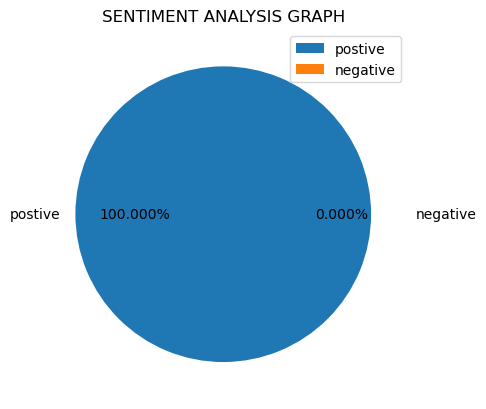

In [20]:

import matplotlib.pyplot as plt
def sentiment_analyse(sentiment_text):
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    neg = score['neg']
    pos = score['pos']
    if neg >pos:
        print("Negative Sentiment")
    elif neg < pos:
        print("Positive Sentiment")
    else:
        print("Neutral Sentiment")
    return pos,neg


pos1, neg1 = sentiment_analyse(text)

if(pos1==0 and neg1==0):
    pos2=50
    neg2=50
else:
    pos2=(pos1/(pos1+neg1))*100
    neg2=(neg1/(pos1+neg1))*100

l=[pos2,neg2]
exp=[0,0.2]
lab=["postive","negative"]
plt.title("sentiment analysis graph".upper())
plt.pie(l,explode=exp,labels=lab,autopct = "%1.3f%%")
plt.legend()
plt.show()

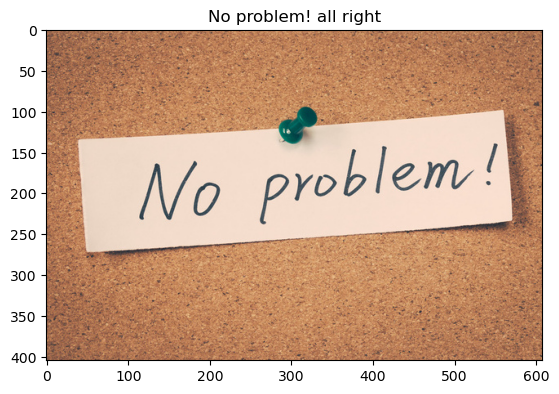

In [21]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

if(pos1<neg1):
    pol,hos,fir=0,0,0
    for i in lemma_words:
        if i in police:
            pol=pol+1
        if i in hospital:
            hos=hos+1
        if i in fire:
            fir=fir+1
    if(pol>0):
        print("police service")
        image = mpimg.imread("police.jpg")
        
        plt.title("police service")
        plt.imshow(image)
        plt.show()
        
    if(hos>0):
        print("Hospital service")
        image = mpimg.imread("hospital.jpg")
        plt.title("Hospital service")
        plt.imshow(image)
        plt.show()

    if(fir>0):
        image = mpimg.imread("fire.jpg")
        plt.title("Fire service and Rescue team")
        plt.imshow(image)
        plt.show()
else:
    image = mpimg.imread("right.jpg")
    plt.title("No problem! all right")
    plt.imshow(image)
    plt.show()

## on speech

In [14]:
from playsound import playsound
import speech_recognition as sr
from googletrans import Translator, LANGUAGES

from gtts import gTTS
import os
import string
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

dic = ('english', 'en','hindi','hi','malayalam', 'ml','tamil', 'ta', 'telugu','te','kannada', 'kn')
lang=input("Enter the languages in the following (english, hindi, tamil, malayalam, telugu, kannada) :")
b=lang.lower()
if(b in dic):
    a=dic[dic.index(b)+1]

def takecommand():
    r = sr.Recognizer()
    with sr.Microphone() as source:
        print("listening.....")
        r.pause_threshold = 1
        audio = r.listen(source)

    try:
        print("Recognizing.....")
        query = r.recognize_google(audio, language=a)
        print(f"The User said {query}\n")
    except Exception as e:
        print("say that again please.....")
        return "None"
    return query

query = takecommand()
while (query == "None"):
    query = takecommand()

translator = Translator()
text_to_translate = translator.translate(query, dest="en")
text1 = text_to_translate.text
print(text1)

Enter the languages in the following (english, hindi, tamil, malayalam, telugu, kannada) :en
listening.....
Recognizing.....
The User said India won the World Cup

India won the World Cup


In [15]:
text=str(text1)
lower_case = text.lower()
cleaned_text = lower_case.translate(str.maketrans('', '', string.punctuation))

tokenized_words = word_tokenize(cleaned_text, "english")
final_words = []

for word in tokenized_words:
    if word not in stopwords.words('english'):
        final_words.append(word)

lemma_words = []
for word in final_words:
    word = WordNetLemmatizer().lemmatize(word)
    lemma_words.append(word)

Positive Sentiment


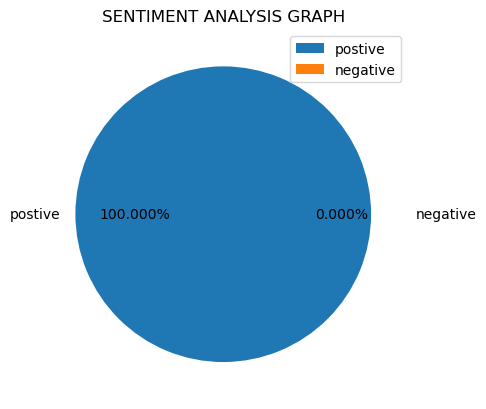

In [16]:
def sentiment_analyse(sentiment_text):
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    neg = score['neg']
    pos = score['pos']
    if neg >pos:
        print("Negative Sentiment")
    elif neg < pos:
        print("Positive Sentiment")
    else:
        print("Neutral Sentiment")
    return pos,neg


pos1, neg1 = sentiment_analyse(cleaned_text)

if(pos1==0 and neg1==0):
    pos2=50
    neg2=50
else:
    pos2=(pos1/(pos1+neg1))*100
    neg2=(neg1/(pos1+neg1))*100

l=[pos2,neg2]
exp=[0,0.2]
lab=["postive","negative"]
plt.title("sentiment analysis graph".upper())
plt.pie(l,explode=exp,labels=lab,autopct = "%1.3f%%")
plt.legend()
plt.show()

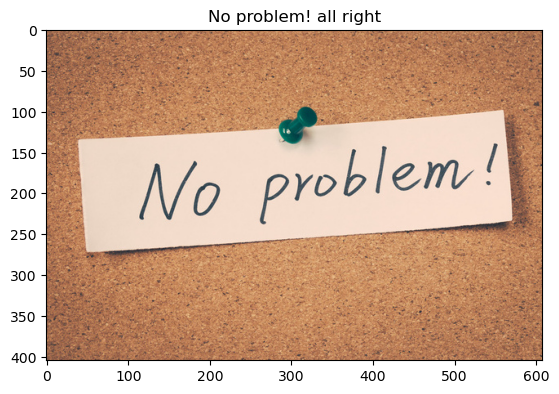

In [17]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

if(pos1<neg1):
    pol,hos,fir=0,0,0
    for i in lemma_words:
        if i in police:
            pol=pol+1
        if i in hospital:
            hos=hos+1
        if i in fire:
            fir=fir+1
    if(pol>0):
        print("police service")
        image = mpimg.imread("police.jpg")
        
        plt.title("police service")
        plt.imshow(image)
        plt.show()
        
    if(hos>0):
        print("Hospital service")
        image = mpimg.imread("hospital.jpg")
        plt.title("Hospital service")
        plt.imshow(image)
        plt.show()

    if(fir>0):
        image = mpimg.imread("fire.jpg")
        plt.title("Fire service and Rescue team")
        plt.imshow(image)
        plt.show()
else:
    image = mpimg.imread("right.jpg")
    plt.title("No problem! all right")
    plt.imshow(image)
    plt.show()